In [3]:
import pandas as pd
import numpy as np

import tubesml as tml

from source.validate import random_split, yearly_split
from source.report import report_points, report_victory, yearly_wrapper
from source.iterate import Iterator

from sklearn.pipeline import Pipeline
from sklearn.model_selection import KFold
from sklearn.metrics import mean_absolute_error

import lightgbm as lgb
import xgboost as xgb

import optuna
from optuna import Trial

In [4]:
df = pd.read_csv('data/processed_women/training_data.csv')

df['seed_round1'] = 0
df['seed_round2'] = 0

df.loc[(df.T1_Seed < 5) & (df.stage_Round1 == 1), 'seed_round1'] = 1
df.loc[(df.T1_Seed < 2) & (df.stage_Round2 == 1), 'seed_round2'] = 1

df['off_edge_Seed'] = df['delta_Seed'] * df['delta_off_edge']
df['def_edge_Seed'] = df['delta_Seed'] * df['delta_def_edge']

df['T1_DR_edge'] = df['T1_DR_opportunity'] - df['T2_OR_opportunity']
df['T2_DR_edge'] = df['T2_DR_opportunity'] - df['T1_OR_opportunity']
df['delta_DR_edge'] = df['T1_DR_edge'] - df['T2_DR_edge']

df['T1_OR_edge'] = df['T1_OR_opportunity'] - df['T2_DR_opportunity']
df['T2_OR_edge'] = df['T2_OR_opportunity'] - df['T1_DR_opportunity']
df['delta_OR_edge'] = df['T1_OR_edge'] - df['T2_OR_edge']

kfolds = KFold(n_splits=7, shuffle=True, random_state=23)

# XGBoost

In [148]:
to_use = ['ID', 'target', 'Season', 'target_points']

d_car = []
t_car = ['Score', 'opp_score', 'FGM_perc', 'Seed', 'Stl', 
         'Blk', 'Ast', 'off_rating', 'def_rating', 'TO']
l2wd_car = []
l2wt_car = []

for c in d_car:
    to_use += [f'delta_{c}'] # f'T1_{c}', f'T2_{c}', 
    
for c in t_car:
    to_use += [f'T1_{c}', f'T2_{c}']
    
for c in l2wd_car:
    to_use += [f'delta_L2W_{c}'] # f'T1_{c}', f'T2_{c}', 
    
for c in l2wt_car:
    to_use += [f'T1_L2W_{c}', f'T2_L2W_{c}']
    
to_use += ['seed_round1', 'off_edge_Seed', 'def_edge_Seed']

In [155]:
scores

,mae_oof,mae_test,mse_oof,mse_test,acc_oof,acc_test,logloss_oof,logloss_test,unsure_oof,unsure_test,year
0,10.4923,8.0568,13.0454,10.8105,0.7910,0.8413,0.4428,0.3888,9.96,4.76,2015
1,10.1940,11.0843,12.8019,13.7162,0.7998,0.7063,0.4361,0.5434,9.79,8.73,2016
2,9.9657,12.2750,12.4632,15.4248,0.7937,0.8254,0.4311,0.4952,10.41,6.35,2017
3,9.8890,12.4384,12.3540,15.3789,0.8025,0.7222,0.4334,0.4876,9.35,9.52,2018
4,10.3208,9.1273,12.9048,11.4455,0.7884,0.8016,0.4454,0.3880,10.93,6.35,2019
5,10.1724,10.5964,12.7166,13.4940,0.7951,0.7794,0.4377,0.4584,10.09,7.14,total


In [5]:
to_use = ['ID', 'target', 'Season', 'target_points']

d_car = []
t_car = ['Score', 'opp_score', 'FGM_perc', 'Seed', 'Stl', 
         'Blk', 'Ast', 'off_rating', 'def_rating', 'TO', 'Away']
l2wd_car = []
l2wt_car = []

for c in d_car:
    to_use += [f'delta_{c}'] # f'T1_{c}', f'T2_{c}', 
    
for c in t_car:
    to_use += [f'T1_{c}', f'T2_{c}']
    
for c in l2wd_car:
    to_use += [f'delta_L2W_{c}'] # f'T1_{c}', f'T2_{c}', 
    
for c in l2wt_car:
    to_use += [f'T1_L2W_{c}', f'T2_L2W_{c}']
    
to_use += ['seed_round1', 'off_edge_Seed', 'def_edge_Seed']

In [362]:
scores

,mae_oof,mae_test,mse_oof,mse_test,acc_oof,acc_test,logloss_oof,logloss_test,unsure_oof,unsure_test,year
0,10.5288,8.2803,13.0254,11.0257,0.7804,0.8571,0.4428,0.3919,9.26,7.94,2015
1,10.1794,10.9787,12.8051,13.6372,0.8034,0.6984,0.4306,0.5354,9.44,10.32,2016
2,9.9786,12.2204,12.4266,15.2815,0.7857,0.8254,0.4297,0.4897,10.41,8.73,2017
3,9.8987,12.2233,12.3531,15.1268,0.7998,0.7143,0.4311,0.4848,8.64,7.94,2018
4,10.3030,9.0630,12.8859,11.3519,0.7901,0.7937,0.4430,0.3826,9.44,7.94,2019
5,10.1777,10.5531,12.7019,13.4071,0.7919,0.7778,0.4350,0.4546,9.44,8.57,total


In [6]:
def cauchyobj(labels, preds):
    c = 7000 
    x =  preds - labels    
    grad = x / (x**2 / c**2 + 1)
    hess = - c**2 *(x**2 - c**2) / (x**2 + c**2)**2
    return grad, hess

2015


MAE train: 			 10.4833
MAE test: 			 8.3447
RMSE train: 			 13.0376
RMSE test: 			 11.1436
Accuracy train: 		 0.7857
Accuracy test: 			 0.8571
Logloss train: 			 0.4424
Logloss test: 			 0.3966
Unsure train: 			 9.61%
Unsure test: 			 8.73%


________________________________________


2016


MAE train: 			 10.2377
MAE test: 			 10.7667
RMSE train: 			 12.8793
RMSE test: 			 13.5373
Accuracy train: 		 0.7998
Accuracy test: 			 0.6984
Logloss train: 			 0.4315
Logloss test: 			 0.5468
Unsure train: 			 9.52%
Unsure test: 			 6.35%


________________________________________


2017


MAE train: 			 10.0588
MAE test: 			 12.0962
RMSE train: 			 12.5567
RMSE test: 			 15.2446
Accuracy train: 		 0.7901
Accuracy test: 			 0.8333
Logloss train: 			 0.431
Logloss test: 			 0.4791
Unsure train: 			 10.05%
Unsure test: 			 9.52%


________________________________________


2018


MAE train: 			 9.8467
MAE test: 			 12.1967
RMSE train: 			 12.3016
RMSE test: 			 15.2017
Accuracy train: 		 0.

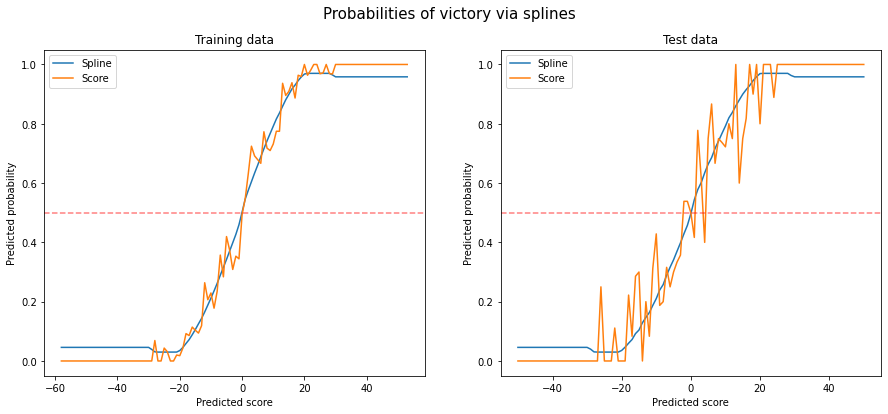

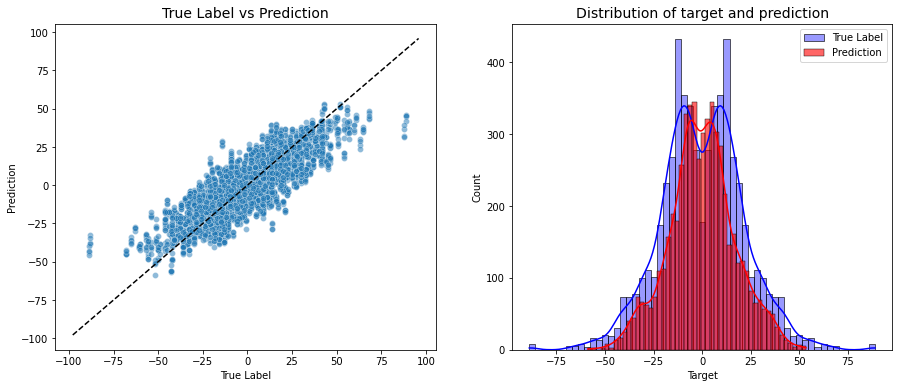

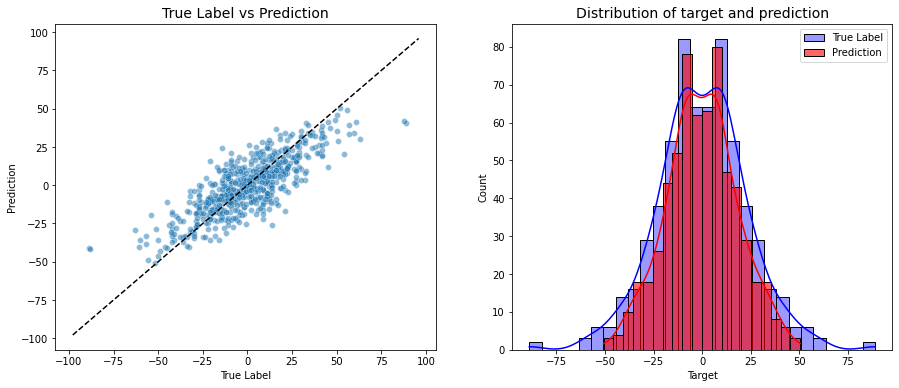

MAE train: 			 10.184
MAE test: 			 10.54
RMSE train: 			 12.7441
RMSE test: 			 13.482
Accuracy train: 		 0.7929
Accuracy test: 			 0.7825
Logloss train: 			 0.4358
Logloss test: 			 0.4584
Unsure train: 			 9.35%
Unsure test: 			 8.41%


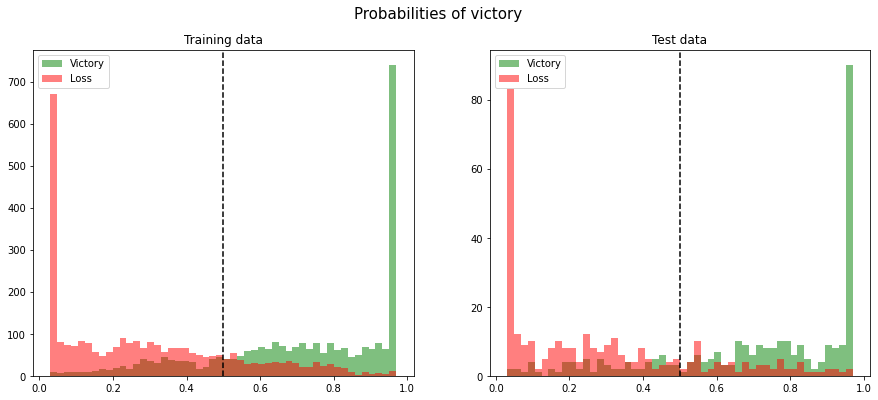

In [12]:
proc_pipe = Pipeline([('scl', tml.DfScaler(method='standard'))])
proc_pipe = Pipeline([('imp', tml.DfImputer())])
estimator = xgb.XGBRegressor(learning_rate=0.01, n_estimators=2000, objective=cauchyobj, max_depth=3,
                                           n_jobs=5, subsample=0.5, reg_alpha=0, reg_lambda=10, colsample_bytree=0.7)
early_stopping = 100
eval_metric = 'mae'
pdp = [col for col in to_use if 'T1_' in col]+['seed_round1']

train_dict = {'trsf_pipe': proc_pipe, 'estimator': estimator, 
              'early_stopping': early_stopping, 'eval_metric': eval_metric, 'pdp': pdp, 'pdp_round': 10}


fitted, oof_pred, test_pred, imp_coef, train, y_train, test, y_test = yearly_split(data=df[to_use], 
                                                                                   model=None, 
                                                                                   kfolds=kfolds, 
                                                                                   target='target_points', 
                                                                                   boost=True, 
                                                                                   **train_dict)

scores = yearly_wrapper(train, test, y_train, y_test, oof_pred, test_pred, points=True)

In [13]:
for yr in imp_coef.keys():
    print(yr, imp_coef[yr]['n_iterations'])

2015 [711, 989, 709, 632, 746, 649, 464]
2016 [718, 897, 556, 1019, 830, 369, 501]
2017 [822, 812, 625, 530, 608, 620, 707]
2018 [728, 810, 648, 715, 1543, 1443, 901]
2019 [519, 794, 586, 735, 778, 512, 901]


In [14]:
coefs  = imp_coef['2019']['feat_imp'].copy()

coefs.columns = ['mean_2019', 'std_2019']

for yr in ['2018', '2017', '2016', '2015']:
    tmp = imp_coef[yr]['feat_imp'].copy()
    tmp.columns = [f'mean_{yr}', f'std_{yr}']
    
    coefs = pd.merge(coefs, tmp, left_index=True, right_index=True)


coefs

,mean_2019,std_2019,mean_2018,std_2018,mean_2017,std_2017,mean_2016,std_2016,mean_2015,std_2015
feat,,,,,,,,,,
def_edge_Seed,0.209867,0.007201,0.209220,0.006133,0.213411,0.009367,0.209336,0.007986,0.200646,0.004702
off_edge_Seed,0.195092,0.004621,0.188943,0.005467,0.188961,0.005516,0.190476,0.005098,0.191625,0.005090
seed_round1,0.118487,0.005766,0.134591,0.009892,0.115815,0.009035,0.113730,0.009991,0.126883,0.009408
T1_quality,0.034779,0.001439,0.030930,0.000762,0.034247,0.000795,0.038864,0.001583,0.032550,0.001394
T2_quality,0.032983,0.001271,0.028183,0.000636,0.030863,0.001184,0.034968,0.001138,0.031484,0.000848
T1_FGM_perc,0.031604,0.001293,0.031102,0.001039,0.034051,0.001209,0.034184,0.001070,0.031512,0.001218
T2_FGM_perc,0.030516,0.001041,0.031120,0.000685,0.033638,0.001579,0.035163,0.001365,0.033490,0.001140
T2_off_rating,0.030413,0.000876,0.032000,0.002203,0.028966,0.001444,0.029434,0.001137,0.028181,0.000956
T1_off_rating,0.030324,0.001222,0.030594,0.000844,0.028369,0.001054,0.029638,0.001003,0.028750,0.000784


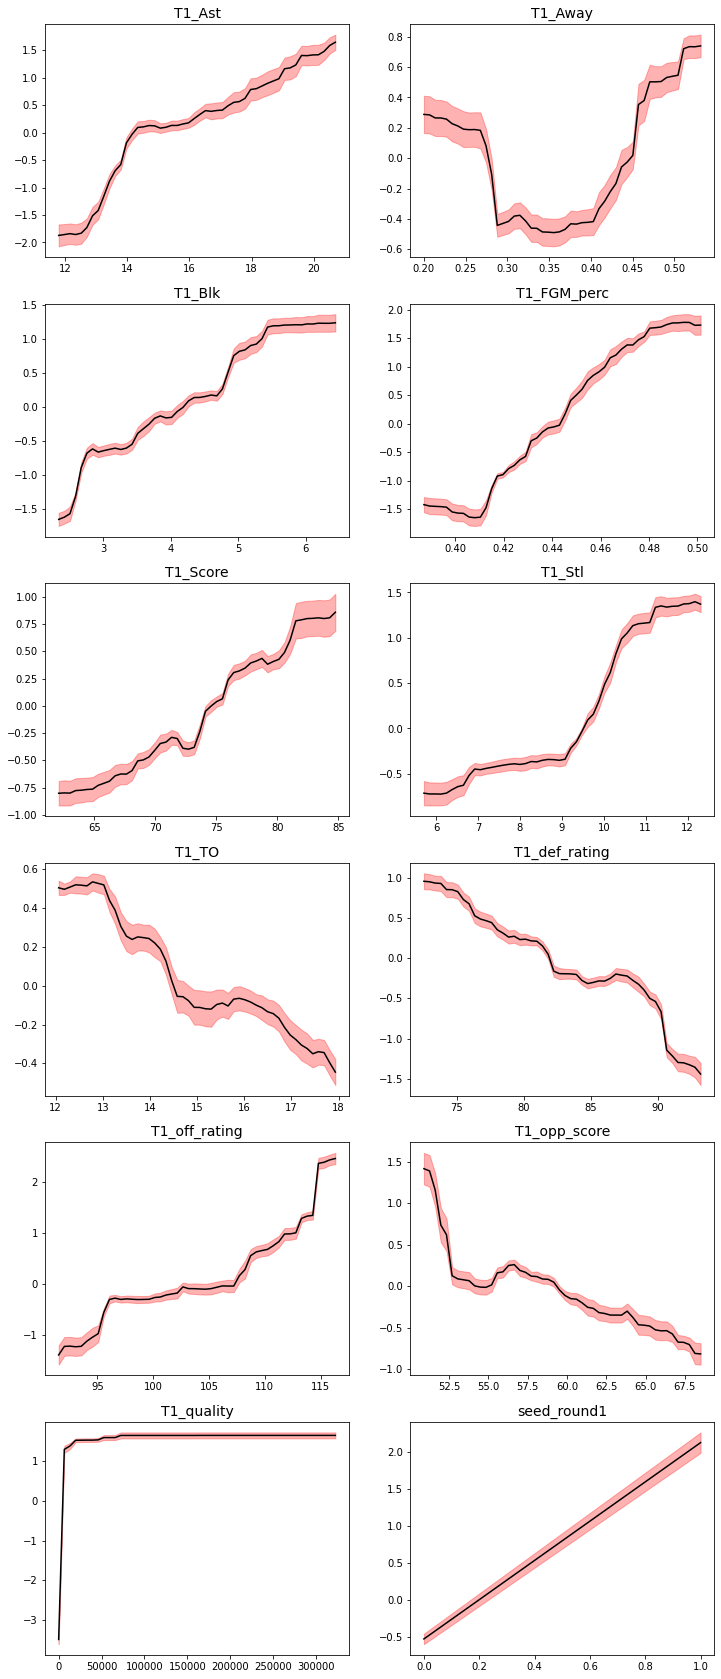

In [15]:
tml.plot_partial_dependence(imp_coef['2019']['pdp'], savename=None)

In [363]:
from source.report import _point_to_proba

In [364]:
for yr in test_pred.keys():
    tmp = test[yr].copy()
    tmp['true_label'] = y_test[yr]
    tmp['true_label'] = np.where(tmp['true_label'] > 0, 1, 0)
    _, tmp['oof_pred'] = _point_to_proba(oof_pred[yr], y_train[yr], test_pred[yr])
    tmp['Season'] = yr
    tmp.to_csv(f'oof/2021_women_xgboost_{yr}.csv', index=False)

In [365]:
tmp = train['2019'].copy()
tmp['true_label'] = y_train[yr]
tmp['true_label'] = np.where(tmp['true_label'] > 0, 1, 0)
tmp['oof_pred'], _ = _point_to_proba(oof_pred['2019'], y_train['2019'], test_pred['2019'])
tmp.to_csv(f'oof/2021_women_xgb_oof.csv',index=False)

In [189]:
train19 = train['2019'].reset_index(drop=True)
y_train19 = y_train['2019'].reset_index(drop=True)

In [7]:
def fit_xgb(trial, train, val, seed=None, num_rounds=5500):
    """Train XGBoost model"""
    X_train, y_train = train
    X_valid, y_valid = val
    metric = 'logloss'
    params = {
        'objective': cauchyobj,
        'max_depth': trial.suggest_int('max_depth', 3, 50),
        'learning_rate': 0.01,
        'reg_alpha': trial.suggest_loguniform('reg_alpha', 1e-8, 10.0),
        'reg_lambda': trial.suggest_loguniform('reg_lambda', 1e-8, 10.0),
        'gamma': trial.suggest_loguniform('gamma', 1e-8, 10.0),
        "subsample": trial.suggest_uniform('subsample', 0.1, 1.0),
        "colsample_bytree": trial.suggest_uniform('colsample_bytree', 0.4, 1.0),
        'n_estimators': num_rounds
    }

    params['seed'] = seed

    early_stop = 100
    verbose_eval = False

    model = xgb.XGBRegressor(**params)

    model.fit(X_train, y_train, early_stopping_rounds=early_stop, 
              eval_set=[(X_train, y_train), (X_valid, y_valid)], eval_metric='mae', verbose=verbose_eval)

    # predictions
    #y_pred_valid = model.predict_proba(X_valid)[:,1]
    y_pred_valid = model.predict(X_valid)
    
    mae = mean_absolute_error(y_valid, y_pred_valid)
    return model, y_pred_valid, mae

In [8]:
train19 = df[[col for col in to_use if col not in ['ID', 'target', 'Season', 'target_points']]]
y_train19 = df['target_points']

In [9]:
def objective(trial: Trial, fast_check=True, target_meter=0, return_info=False):
    folds = 7
    seed = 345
    shuffle = True
    kf = KFold(n_splits=folds, shuffle=shuffle, random_state=seed)

    y_valid_pred_total = np.zeros(train19.shape[0])

    models = []
    valid_score = 0
    for train_idx, valid_idx in kf.split(train19, y_train19):
        train_data = train19.iloc[train_idx,:], y_train19.iloc[train_idx]
        valid_data = train19.iloc[valid_idx,:], y_train19.iloc[valid_idx]

        model, y_pred_valid, log = fit_xgb(trial, train_data, valid_data,
                                            num_rounds=5000)
        y_valid_pred_total[valid_idx] = y_pred_valid
        models.append(model)
        valid_score += log
        if fast_check:
            break
    valid_score /= len(models)
    if return_info:
        return valid_score, models, y_pred_valid, y_train
    else:
        return valid_score

In [10]:
optuna.logging.set_verbosity(optuna.logging.ERROR)

In [11]:
study = optuna.create_study()
study.optimize(objective, n_trials=1000)

In [12]:
study.best_trial.params

{'max_depth': 48,
 'reg_alpha': 0.025543580308101586,
 'reg_lambda': 3.873771216495863e-06,
 'gamma': 4.230634659526698e-06,
 'subsample': 0.11616188997705858,
 'colsample_bytree': 0.8653657735190887}

2015


MAE train: 			 10.5828
MAE test: 			 7.8494
RMSE train: 			 13.1499
RMSE test: 			 10.7719
Accuracy train: 		 0.7822
Accuracy test: 			 0.8492
Logloss train: 			 0.4487
Logloss test: 			 0.4015
Unsure train: 			 9.96%
Unsure test: 			 6.35%


________________________________________


2016


MAE train: 			 10.0725
MAE test: 			 10.9326
RMSE train: 			 12.7303
RMSE test: 			 13.5279
Accuracy train: 		 0.7989
Accuracy test: 			 0.7143
Logloss train: 			 0.4327
Logloss test: 			 0.5303
Unsure train: 			 10.67%
Unsure test: 			 11.11%


________________________________________


2017


MAE train: 			 9.9556
MAE test: 			 12.2071
RMSE train: 			 12.4764
RMSE test: 			 15.1114
Accuracy train: 		 0.7875
Accuracy test: 			 0.8254
Logloss train: 			 0.4335
Logloss test: 			 0.4935
Unsure train: 			 10.32%
Unsure test: 			 9.52%


________________________________________


2018


MAE train: 			 9.8143
MAE test: 			 12.3867
RMSE train: 			 12.3773
RMSE test: 			 15.1213
Accuracy train: 		 

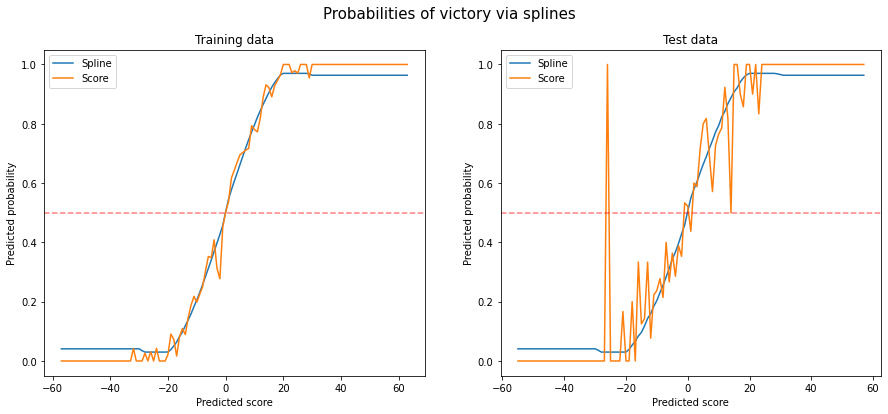

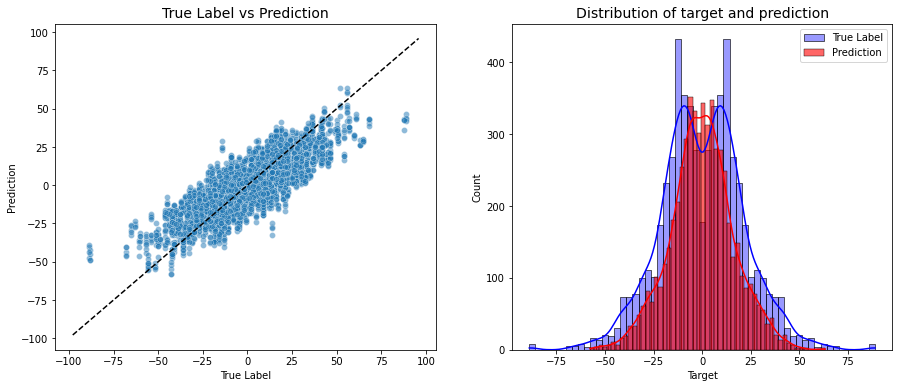

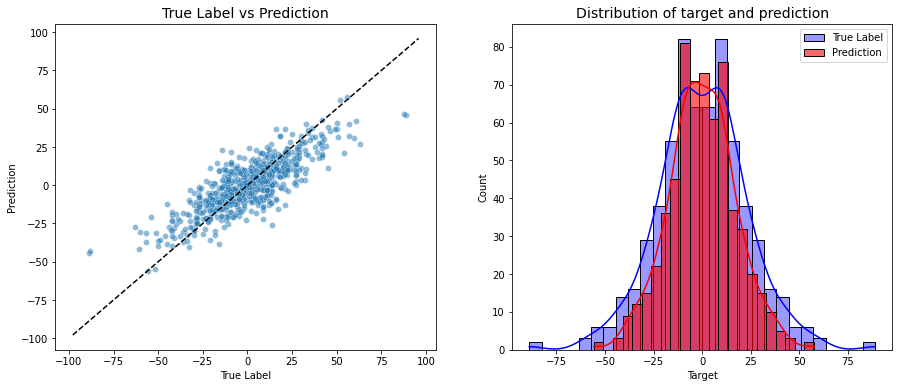

MAE train: 			 10.1368
MAE test: 			 10.4217
RMSE train: 			 12.7343
RMSE test: 			 13.2623
Accuracy train: 		 0.7887
Accuracy test: 			 0.7873
Logloss train: 			 0.4393
Logloss test: 			 0.4569
Unsure train: 			 10.21%
Unsure test: 			 8.57%


,mae_oof,mae_test,mse_oof,mse_test,acc_oof,acc_test,logloss_oof,logloss_test,unsure_oof,unsure_test,year
0,10.5828,7.8494,13.1499,10.7719,0.7822,0.8492,0.4487,0.4015,9.96,6.35,2015
1,10.0725,10.9326,12.7303,13.5279,0.7989,0.7143,0.4327,0.5303,10.67,11.11,2016
2,9.9556,12.2071,12.4764,15.1114,0.7875,0.8254,0.4335,0.4935,10.32,9.52,2017
3,9.8143,12.3867,12.3773,15.1213,0.7937,0.7381,0.4326,0.4926,9.79,6.35,2018
4,10.2590,8.7328,12.9218,11.1082,0.7813,0.8095,0.4486,0.3823,10.32,9.52,2019
5,10.1368,10.4217,12.7343,13.2623,0.7887,0.7873,0.4393,0.4569,10.21,8.57,total


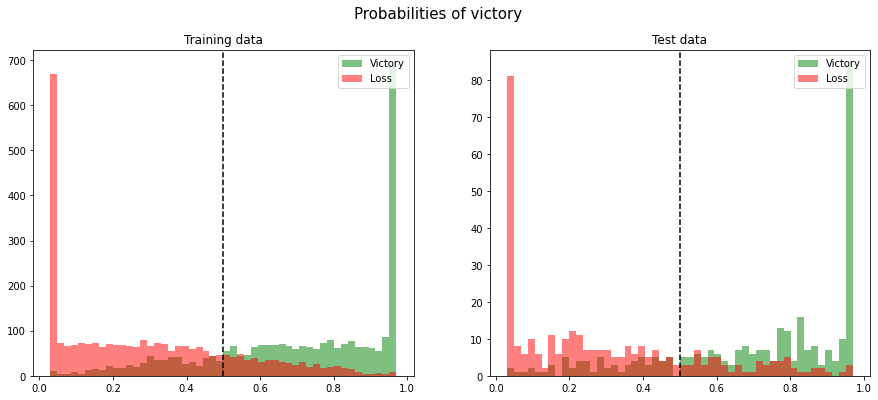

In [17]:
proc_pipe = Pipeline([('scl', tml.DfImputer())])
estimator = xgb.XGBRegressor(**study.best_trial.params, n_estimators=4000, learning_rate=0.01, random_state=24, n_jobs=-1)
early_stopping = 100
eval_metric = 'mae'
pdp = [col for col in to_use if 'T1_' in col]+['seed_round1']

train_dict = {'trsf_pipe': proc_pipe, 'estimator': estimator, 
              'early_stopping': early_stopping, 'eval_metric': eval_metric, 'pdp': pdp, 'pdp_round': 10}


fitted, oof_pred, test_pred, imp_coef, train, y_train, test, y_test = yearly_split(data=df[to_use], 
                                                                                   model=None, 
                                                                                   kfolds=kfolds, 
                                                                                   target='target_points', 
                                                                                   boost=True, 
                                                                                   **train_dict)

yearly_wrapper(train, test, y_train, y_test, oof_pred, test_pred, points=True)

In [18]:
for yr in imp_coef.keys():
    print(yr, imp_coef[yr]['n_iterations'])

2015 [412, 269, 245, 430, 310, 411, 306]
2016 [380, 273, 388, 321, 408, 300, 368]
2017 [274, 292, 305, 370, 459, 406, 395]
2018 [338, 275, 295, 423, 350, 297, 325]
2019 [308, 214, 274, 417, 439, 224, 453]


In [19]:
coefs  = imp_coef['2019']['feat_imp'].copy()

coefs.columns = ['mean_2019', 'std_2019']

for yr in ['2018', '2017', '2016', '2015']:
    tmp = imp_coef[yr]['feat_imp'].copy()
    tmp.columns = [f'mean_{yr}', f'std_{yr}']
    
    coefs = pd.merge(coefs, tmp, left_index=True, right_index=True)


coefs

,mean_2019,std_2019,mean_2018,std_2018,mean_2017,std_2017,mean_2016,std_2016,mean_2015,std_2015
feat,,,,,,,,,,
def_edge_Seed,0.149844,0.006297,0.148612,0.004259,0.138754,0.008235,0.150044,0.009252,0.147399,0.010058
off_edge_Seed,0.140137,0.004111,0.144522,0.002366,0.138920,0.006977,0.144973,0.007886,0.144357,0.010017
seed_round1,0.132686,0.030473,0.117420,0.018415,0.148499,0.043111,0.117880,0.039941,0.127953,0.049287
T1_off_rating,0.041006,0.001869,0.042982,0.001661,0.038290,0.001437,0.043560,0.002105,0.040112,0.002243
T2_off_rating,0.039385,0.002345,0.040115,0.001793,0.037225,0.002364,0.042691,0.002446,0.040673,0.003245
T2_Seed,0.039204,0.003226,0.040481,0.002728,0.039081,0.002878,0.036929,0.002423,0.036886,0.002770
T2_Ast,0.035589,0.001674,0.036644,0.000994,0.036083,0.001885,0.035020,0.001675,0.035579,0.001801
T1_Ast,0.035257,0.001691,0.036981,0.001622,0.036430,0.002111,0.035437,0.001869,0.036343,0.002105
T1_def_rating,0.034568,0.001692,0.035360,0.000852,0.035106,0.001587,0.034701,0.001915,0.033872,0.002024


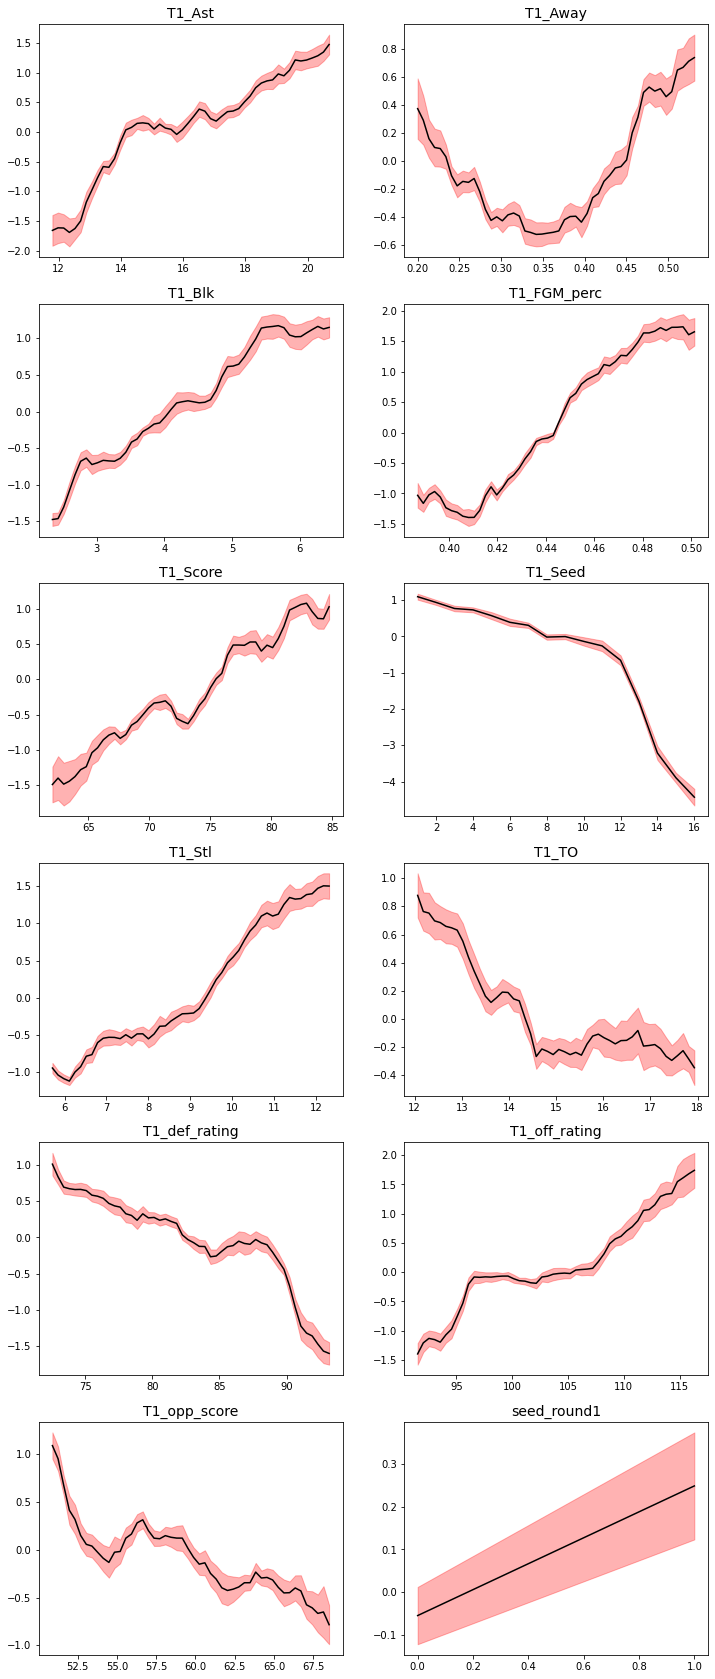

In [20]:
tml.plot_partial_dependence(imp_coef['2019']['pdp'], savename=None)

In [14]:
to_use = ['ID', 'target', 'Season', 'target_points']

car = ['Score', 'opp_score', 'True_shooting_perc', 
       'Stl', 'OR', 'off_rating', 'def_rating', 'TO', 'DR_edge'] 

for c in car:
    to_use += [f'delta_{c}'] # f'T1_{c}', f'T2_{c}', 

to_use += ['seed_round1', 'seed_round2', 'off_edge_Seed', 'def_edge_Seed'] 

In [43]:
pipe = Pipeline([('scl', tml.DfScaler()),
                 #('PCA', tml.DfPCA(n_components=0.7, compress=True, random_state=24)),
                 ('lgb', lgb.LGBMRegressor(learning_rate=0.1, n_estimators=600, objective=cauchyobj,
                                           n_jobs=5, subsample=0.7, reg_alpha=5, reg_lambda=1))])

grid_param = {'scl__method': ['standard', 'robust'], 
              'PCA__n_components': [0.5, 0.6, 0.7, 0.8, 0.9], 
              'lgb__num_leaves': [10, 40, 70, 100], 
              'lgb__reg_alpha': [0, 0.5, 1, 2, 5], 
              'lgb__reg_lambda': [0, 0.5, 1, 2, 5]}

fitted, oof_pred, test_pred, imp_coef, train, y_train, test, y_test = yearly_split(df[to_use], pipe, kfolds, 'target_points', tune=False, param_grid=grid_param)

2015


MAE train: 			 9.2914
MAE test: 			 7.7842
RMSE train: 			 11.7705
RMSE test: 			 10.1805
Accuracy train: 		 0.6984
Accuracy test: 			 0.7222
AUC ROC train: 			 0.6984
AUC ROC test: 			 0.7222
Logloss train: 			 0.553
Logloss test: 			 0.5025
Unsure train: 			 18.2%
Unsure test: 			 22.22%


________________________________________


2016


MAE train: 			 9.2709
MAE test: 			 9.8471
RMSE train: 			 11.7122
RMSE test: 			 12.3281
Accuracy train: 		 0.6969
Accuracy test: 			 0.7063
AUC ROC train: 			 0.6969
AUC ROC test: 			 0.7063
Logloss train: 			 0.5558
Logloss test: 			 0.5746
Unsure train: 			 19.69%
Unsure test: 			 14.29%


________________________________________


2017


MAE train: 			 9.2455
MAE test: 			 8.313
RMSE train: 			 11.7268
RMSE test: 			 11.0625
Accuracy train: 		 0.6944
Accuracy test: 			 0.7698
AUC ROC train: 			 0.6944
AUC ROC test: 			 0.7698
Logloss train: 			 0.5496
Logloss test: 			 0.4985
Unsure train: 			 18.4%
Unsure test: 			 15.87%


____________

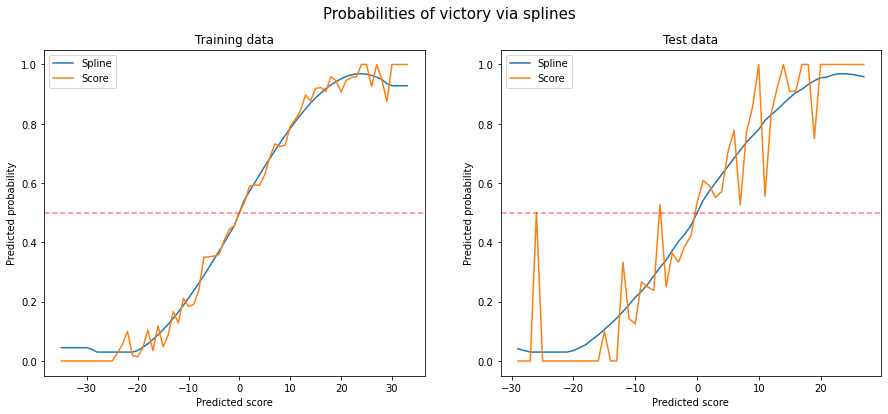

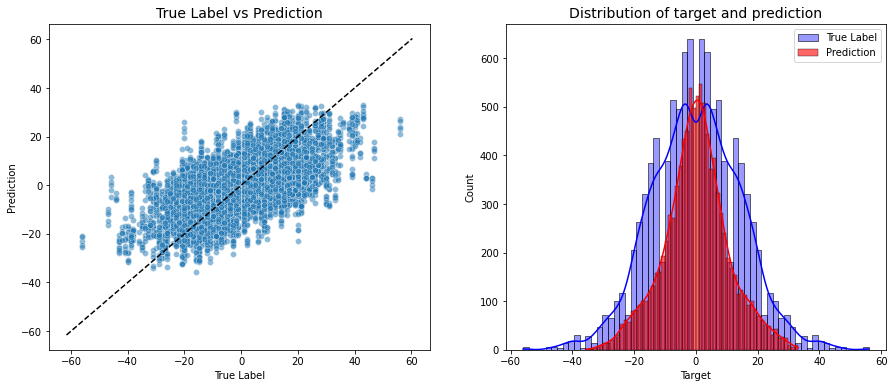

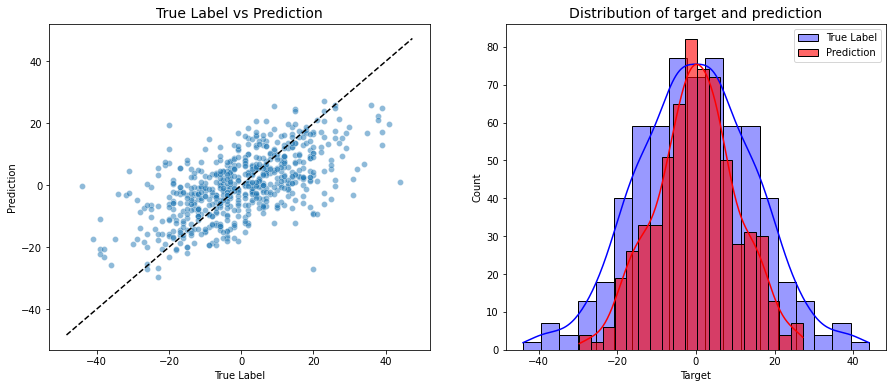

MAE train: 			 9.2317
MAE test: 			 9.0747
RMSE train: 			 11.691
RMSE test: 			 11.7364
Accuracy train: 		 0.6967
Accuracy test: 			 0.7302
AUC ROC train: 			 0.6967
AUC ROC test: 			 0.7302
Logloss train: 			 0.5529
Logloss test: 			 0.5295
Unsure train: 			 18.91%
Unsure test: 			 16.19%


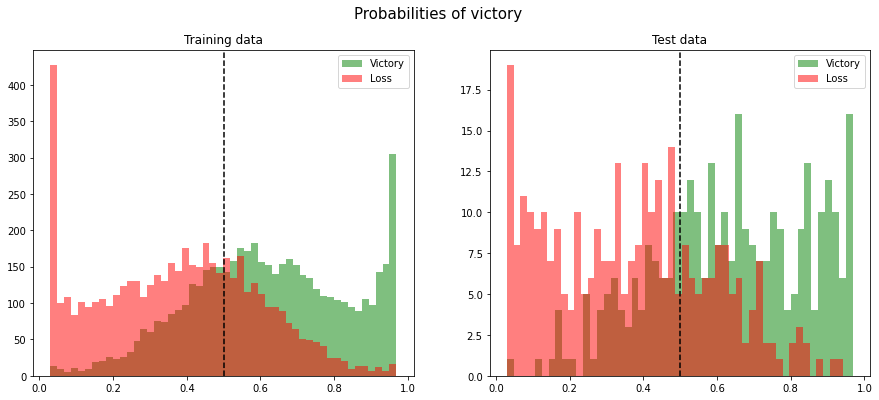

In [44]:
yearly_wrapper(train, test, y_train, y_test, oof_pred, test_pred, points=True)

In [40]:
pipe = Pipeline([('scl', tml.DfScaler()),
                 #('PCA', tml.DfPCA(n_components=0.9, compress=True, random_state=24)),
                 ('lgb', lgb.LGBMClassifier(learning_rate=0.1, n_estimators=500, num_leaves=150, max_depth=5,
                                           n_jobs=5, subsample=0.7, reg_alpha=1, reg_lambda=1))])

grid_param = {'scl__method': ['standard', 'robust'], 
               'PCA__n_components': [0.5, 0.6, 0.7, 0.8, 0.9], 
               'lgb__num_leaves': [10, 40, 70, 100], 
              'lgb__reg_alpha': [0, 0.5, 1, 2, 5], 
              'lgb__reg_lambda': [0, 0.5, 1, 2, 5]}

fitted, oof_pred, test_pred, imp_coef, train, y_train, test, y_test = yearly_split(df[to_use], pipe, kfolds, 'target', tune=False, 
                                                                                   param_grid=grid_param, predict_proba=True)

2015


Accuracy train: 		 0.684
Accuracy test: 			 0.7857
AUC ROC train: 			 0.684
AUC ROC test: 			 0.7857
Logloss train: 			 0.6585
Logloss test: 			 0.5001
Unsure train: 			 11.2103%
Unsure test: 			 11.1111%


________________________________________


2016


Accuracy train: 		 0.6944
Accuracy test: 			 0.6825
AUC ROC train: 			 0.6944
AUC ROC test: 			 0.6825
Logloss train: 			 0.6417
Logloss test: 			 0.7175
Unsure train: 			 11.1607%
Unsure test: 			 10.3175%


________________________________________


2017


Accuracy train: 		 0.6925
Accuracy test: 			 0.7143
AUC ROC train: 			 0.6925
AUC ROC test: 			 0.7143
Logloss train: 			 0.6601
Logloss test: 			 0.6461
Unsure train: 			 11.2103%
Unsure test: 			 9.5238%


________________________________________


2018


Accuracy train: 		 0.6935
Accuracy test: 			 0.7698
AUC ROC train: 			 0.6935
AUC ROC test: 			 0.7698
Logloss train: 			 0.6396
Logloss test: 			 0.6244
Unsure train: 			 12.4504%
Unsure test: 			 7.9365%


___________

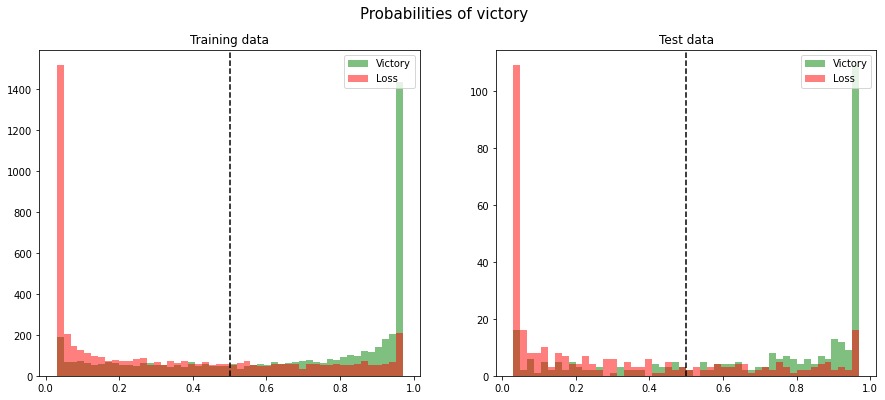

In [41]:
yearly_wrapper(train, test, y_train, y_test, oof_pred, test_pred, points=False)

In [42]:
imp_coef['2019'].head(20)

,mean,std
feat,,
T2_def_rating,270.571429,13.270387
T1_def_rating,268.000000,11.234866
T2_Blk,257.714286,8.322374
T1_DR,256.857143,10.191032
T1_Blk,256.000000,11.669047
T1_FGM_perc,246.142857,12.757195
T2_DR,239.000000,8.343327
T2_Stl,234.000000,13.603513
T2_Ast,230.571429,10.197650
